# Spot detection with napari


### Overview
In this activity, we will perform spot detection on some in situ sequencing data ([Feldman and Singh et al., Cell, 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)31067-0s)). In doing so, we will combine methods from [scipy](https://www.scipy.org/), [scikit-image](https://scikit-image.org/), and [cellpose](https://github.com/MouseLand/cellpose). The goal is to familiarize you with performing analysis that integrates the scientific python ecosystem and napari.

### Data source

The data were downloaded from the [OpticalPooledScreens github repository](https://github.com/feldman4/OpticalPooledScreens).

### Next steps

Following this activity, we will use the workflow generated in this activity to create a napari spot detection plugin. 

### screenshots
For the solution notebook, we are including screenshots via the `nbscreenshot` utility. These are not required for your notebook.

An example usage: `nbscreenshot(viewer)`

In [1]:
from napari.utils import nbscreenshot

# Load the data

In the cells below load the data using the scikit-image `imread()` function. For more information about the `imread()` function, please see the [scikit-image docs](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread). We are loading two images:

- `nuclei`: an image of cell nuclei
- `spots`: an image of in situ sequencing spots

In [2]:
from skimage import io

nuclei_url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/nuclei_cropped.tif'
nuclei = io.imread(nuclei_url)

spots_url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/spots_cropped.tif'
spots = io.imread(spots_url)

# View the data

We will use napari to view our data. To do so, we first must create the viewer. Once the Viewer is created, we can add images to the viewer via the Viewer's `add_image()` method. 

In [3]:
import napari

# create the napari viewer
viewer = napari.Viewer();

# add the nuclei image to the viewer
viewer.add_image(nuclei);


In the cell below, add the spots image to the viewer as was done above for the nuclei image. After loading the data, inspect it in the viewer and adjust the layer settings to your liking (e.g., contrast limits, colormap). You can pan/zoom around the image by click/dragging to pan and scrolling with your mousewheel or trackpad to zoom.

**Hint**: you can adjust a layer's opacity to see the change how much you see of the layers that are "under" it.

In [4]:
# add the spots image to the viewer
viewer.add_image(spots)


<Image layer 'spots' at 0x7fe99659d8b0>

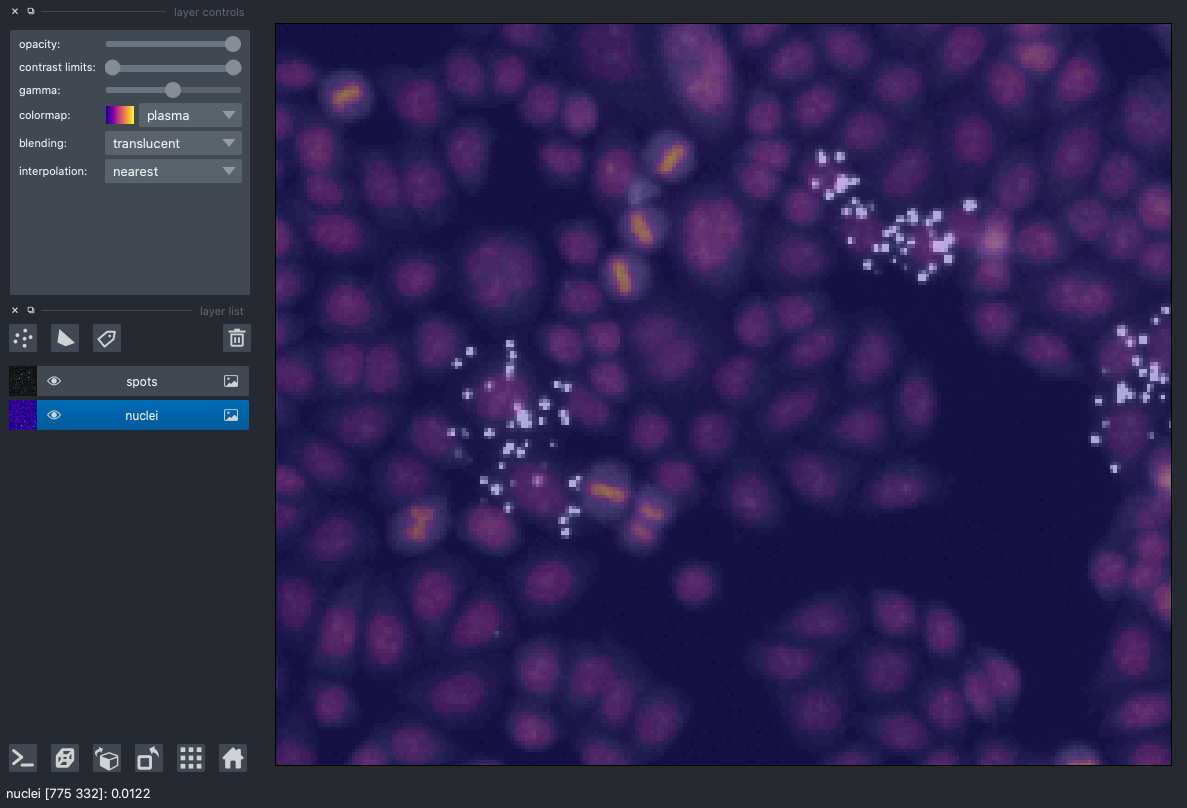

In [6]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

# Create an image filter

You may have noticed the the spots image contains background and autofluorescence from the cells. To improve spot detection, we will apply a high pass filter to improve the contrast of the spots.

In [5]:
import numpy as np
from scipy import ndimage as ndi

def gaussian_high_pass(image: np.ndarray, sigma: float = 2):
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image to be filtered.
    sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    
    Returns
    -------
    high_passed_im : np.ndarray
        The image with the high pass filter applied
    """
    low_pass = ndi.gaussian_filter(image, sigma)
    high_passed_im = image - low_pass
    
    return high_passed_im

In the cell below, apply the gaussian high pass filter to the `spots` image and add the image to the viewer.

In [16]:
# Use the gaussian_high_pass function to filter the spots image
filtered_spots = gaussian_high_pass(spots, 2)

# add the filtered image to the viewer
# hint: set the opacity < 1 in order to see the layers underneath
viewer.add_image(filtered_spots, opacity=0.6, colormap='viridis')

<Image layer 'filtered_spots' at 0x7fe9977123a0>

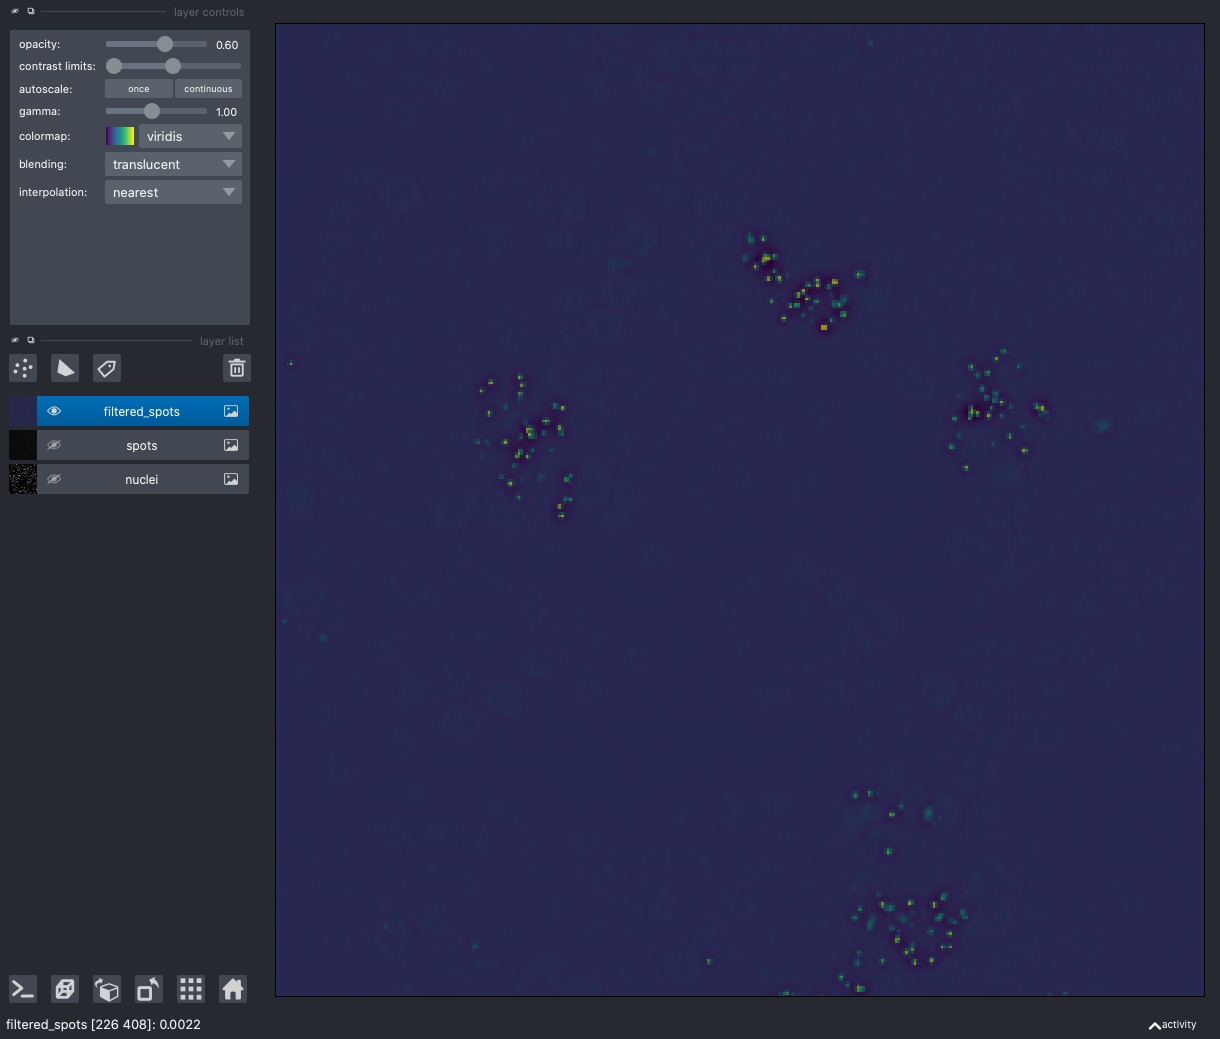

In [18]:
nbscreenshot(viewer)

# Detect spots

Next, we will create a function to detect the spots in the spot image. This function should take the raw image, apply the gaussian high pass filter from above and then use one of the blob detection algorithms from sci-kit image to perform the blob detection. The `detect_spots()` function should return a numpy array containing the coordinates of each spot and a numpy array containing the diameter of each spot.

Some hints:
- See the [blob detection tutorial from scikit-image](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html). - We recommend the [blob_log detector](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log), but feel free to experiment!
- See the "Note" from the blob_log docs: "The radius of each blob is approximately $\sqrt{2}\sigma$ for a 2-D image"

In [19]:
import numpy as np
from skimage.feature import blob_log

def detect_spots(
    image: np.ndarray,
    high_pass_sigma: float = 2,
    spot_threshold: float = 0.01,
    blob_sigma: float = 2
):
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image in which to detect the spots.
    high_pass_sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    spot_threshold : float
        The threshold to be passed to the blob detector.
        The default value is 0.01.
    blob_sigma: float
        The expected sigma (width) of the spots. This parameter
        is passed to the "max_sigma" parameter of the blob
        detector.
    
    Returns
    -------
    points_coords : np.ndarray
        An NxD array with the coordinate for each detected spot.
        N is the number of spots and D is the number of dimensions.
    sizes : np.ndarray
        An array of size N, where N is the number of detected spots
        with the diameter of each spot.
    
    """
    # filter the image
    filtered_spots = gaussian_high_pass(image, high_pass_sigma)

    # detect the spots on the filtered image
    blobs_log = blob_log(
        filtered_spots,
        max_sigma=blob_sigma,
        num_sigma=1,
        threshold=spot_threshold
    )
    
    # convert the output of the blob detector to the 
    # desired points_coords and sizes arrays
    # (see the docstring for details)
    points_coords = blobs_log[:, 0:2]
    sizes = 2 * np.sqrt(2) * blobs_log[:, 2]

    return points_coords, sizes

In the cell below, apply `detect_spots()` to our `spots` image. To visualize the results, add the spots to the viewer as a [Points layer](https://napari.org/tutorials/fundamentals/points.html). If you would like to see an example of using a points layer, see [this example](https://github.com/napari/napari/blob/master/examples/add_points.py). To test out your function, vary the detection parameters and see how they affect the results. Note that each time you run the cell, the new results are added as an additional Points layer, allowing you to compare results from different parameters. To make it easier to compare results, you can try modifying the layer opacity or toggling the visibility with the "eye" icon in the layer list.

In [20]:
# detect the spots
spot_coords, spot_sizes = detect_spots(
    spots,
    high_pass_sigma=2,
    spot_threshold=0.01,
    blob_sigma=2
)

# add the detected spots to the viewer as a Points layer
viewer.add_points(
    spot_coords,
    size=spot_sizes,
    opacity=0.5
)

<Points layer 'spot_coords' at 0x7fe999d2d5e0>

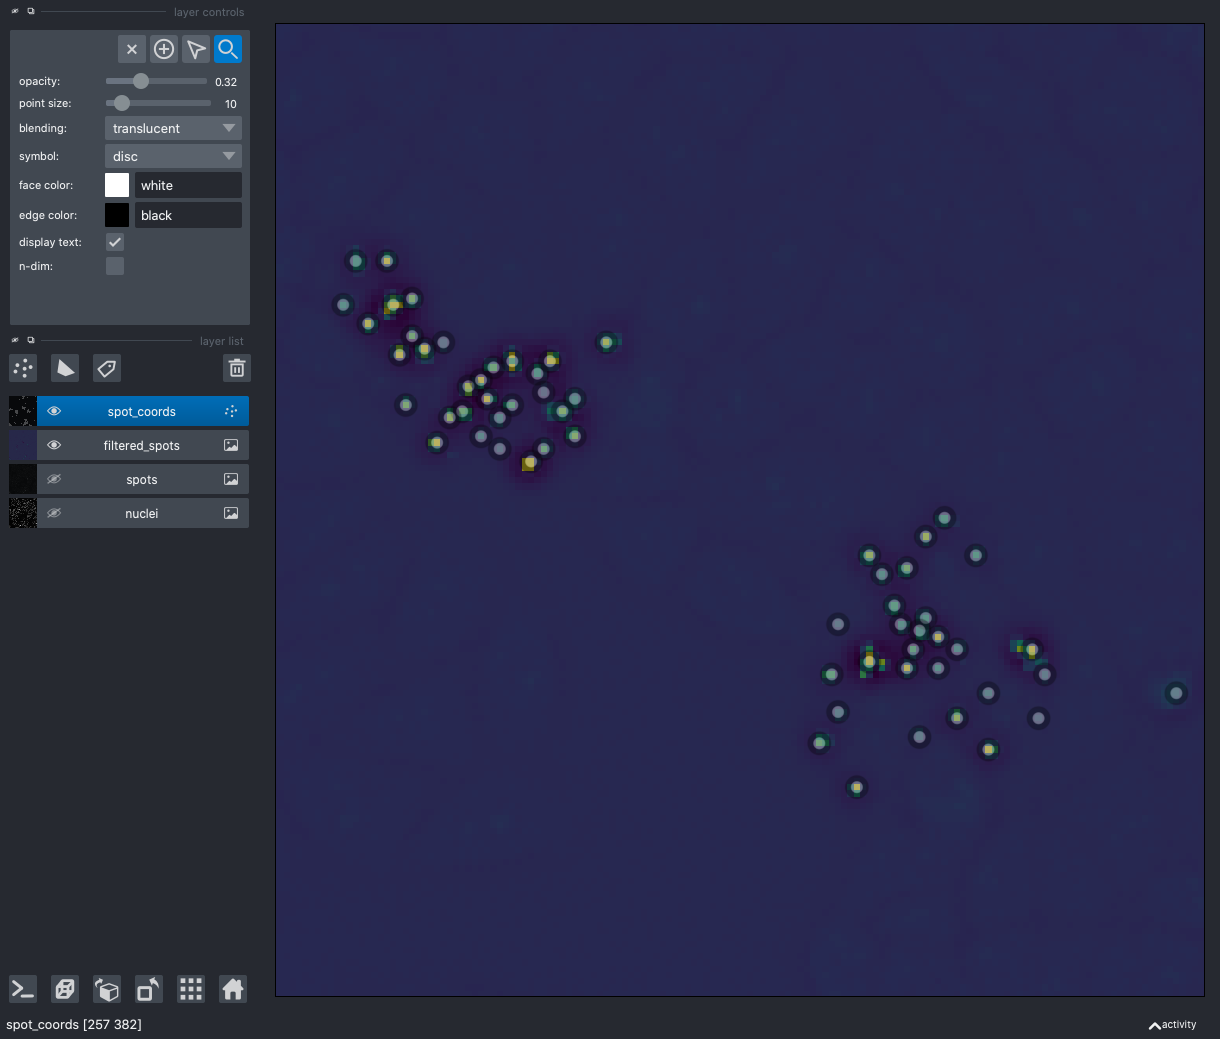

In [21]:
nbscreenshot(viewer)

## Conclusion

In this activity, we have interactively prototyped a spot detection function using a combination of jupyter notebook, scipy, scikit-image, and napari. In the next activity, we will take the spot detection function we created and turn it into a napari plugin.